In [60]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import tensorflow.keras.losses
import math

In [55]:
#Loads in real STM images and crops them
def crop_STM(arr,xy,size):
    x,y = xy
    return arr[y:y+size,x:x+size]
image_offset=[128,64]
im=image.load_img("MoC2 _ 349.jpg")
im_arr=image.img_to_array(im).astype('int')
im_arr=crop_STM(im_arr,image_offset,32)
im_arr_batch=np.array([im_arr])

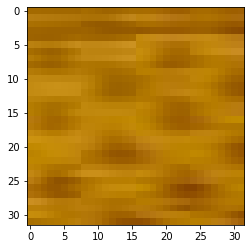

In [56]:
plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)

In [19]:
#Loads in a testing image
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Testing_set_6_16'
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))

index=0
test_im=image.load_img(os.path.join(test_dataset_dir,dft['filename'][index]))
test_im_arr=image.img_to_array(test_im)
test_im_arr=np.array([test_im_arr])

In [57]:
#Creates data generators to load images into the model
predict_datagen = ImageDataGenerator(rescale=1./255) 
predict_generator= predict_datagen.flow(
    im_arr_batch,
    batch_size=1
    )
predict_test_datagen=ImageDataGenerator(rescale=1./255)
predict_test_generator=predict_test_datagen.flow(
    test_im_arr,
    batch_size=1
    )

In [31]:
#Loads in the proper model
model_name='100erun6_17_halfset'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])

In [58]:
#uses the model to predict center atom and neighbors, assigns locations and vectors accordingly
prediction=model.predict(predict_generator)
prediction=prediction[0]
center_atom=np.array([prediction[0],prediction[1]])*32
neighborvec1=np.array([prediction[2],prediction[3]])*32
neighborvec2=np.array([prediction[4],prediction[5]])*32
neighborvec3=np.array([prediction[6],prediction[7]])*32

In [64]:
def color_central_atom(arr):
    for i in range(3):
                arr[math.floor(center_atom[1])][math.floor(center_atom[0])][i]=255
    return arr 

def color_neighbors(arr):
    neighbors=[]
    neighbors.append(center_atom+neighborvec1)
    neighbors.append(center_atom+neighborvec2)
    neighbors.append(center_atom+neighborvec3)
    i=0
    for n in neighbors:
        if n[0]<arr.shape[1] and n[1]<arr.shape[0]:
            arr[math.floor(n[1])][math.floor(n[0])][i]=225
            arr[math.floor(n[1])][math.floor(n[0])][i-1]=0
            arr[math.floor(n[1])][math.floor(n[0])][i-2]=0
        i+=1
    return arr

def color_im(arr):
    arr=color_central_atom(arr)
    arr=color_neighbors(arr)
    return arr

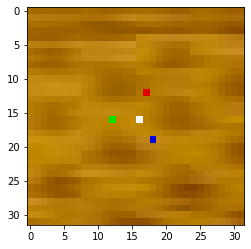

In [65]:
im_arr=color_im(im_arr)
plt.figure()
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)